# Case - Identify a pricing strategy that maximizes profit over 12 months

### Constants
* 10000 potential users
* each user costs 30 dollars to acquire
* each ride generates 40 dollars of revenue
* inf potential drivers (assumption is driver supply is deep)

### Monthly choices
* choose a price to pay drivers
* choose a number of new users (up to 1000) to acquire

### Probability of making a ride request is tied to a Poisson distribution
* newly acquired users: mean number of requests **mu** is equal to 1
* existing users: mean number of requests is equal to the number of matched rides in the previous month

### Probability of a ride request being matched is tied to price (pay of drivers)
* csv file links driver's pay **(PAY)** and whether the ride request was accepted or not **(ACCEPTED)**



# Strategy

To identify an optimal pricing strategy, we need to:
1. Model the probability of a request being matched given the selected price to pay drivers.
2. Model the number of requests made by new and existing users.
3. Define a pricing strategy that calculates profit given the selected 12 month schedule of (i) price to pay drivers and (ii) number of new users to acquire.
4. Optimize the pricing strategy to maximize profit.

In [4]:
# import libraries
import pandas as pd
import numpy as np
import itertools
from functools import lru_cache
from sklearn.linear_model import LogisticRegression
from scipy.stats import poisson
from scipy.optimize import minimize, Bounds, SR1
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Model the probability that a request is matched

Let's first look at the historical data for pricing and driver acceptance.

In [5]:
# visualize driver pay for accepted vs non-accepted rides
df = pd.read_csv('driverAcceptanceData.csv')
ride_accepted = df[df['ACCEPTED'] == 1].pop('PAY')
ride_declined = df[df['ACCEPTED'] == 0].pop('PAY')

In [6]:
# nan check: no null values in dataset
df.isnull().sum()

Unnamed: 0    0
PAY           0
ACCEPTED      0
dtype: int64

<AxesSubplot:xlabel='ACCEPTED', ylabel='PAY'>

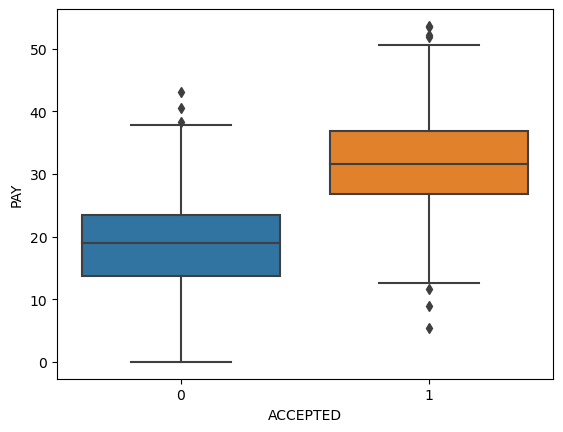

In [7]:
# outliers check: no outliers in dataset
sns.boxplot(x='ACCEPTED', y = 'PAY', data = df)

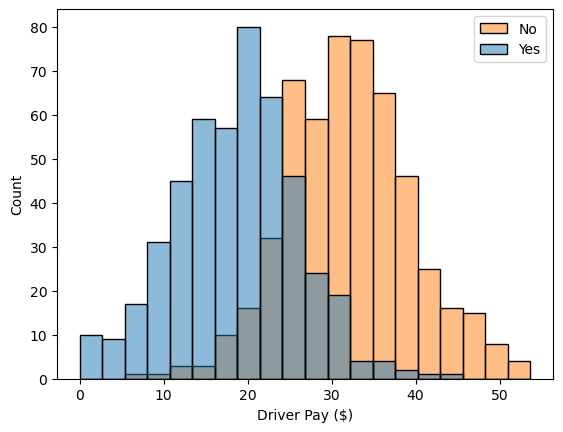

In [8]:
# histograms to check distributions
hist = sns.histplot(x='PAY', hue='ACCEPTED', data = df)
plt.xlabel('Driver Pay ($)')
plt.legend(labels=['No','Yes'])

The pricing data looks clean, let's try using logistic regression to model the relationship. 

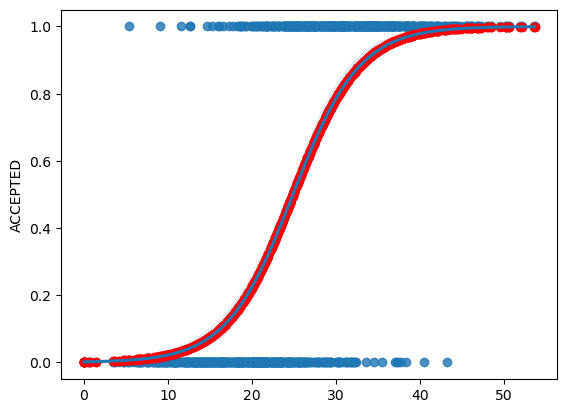

In [9]:
X = df['PAY'].values.reshape(-1,1)
y = df['ACCEPTED']
pricing_model = LogisticRegression().fit(X,y)
p_accepted = pricing_model.predict_proba(X)[:,1]

sns.regplot(x= X, y= y, logistic= True)
plt.scatter(X, p_accepted, c = 'r')

In [10]:
# sanity check: probability of a match at price = 25 should be about 0.5
pricing_model.predict_proba([[25]])[:,1]

array([0.50769654])

## 2. Model the number of requests.

Now that we know the probability of a match, we need to estimate the number of requests that will be made.

Requests are assumed to follow a Poisson distribution. Newly acquired users start at lambda = 1, meaning they will make one request on average. Let's start here by seeing how requests work out for 100 newly acquired users.

In [11]:
lam = 1
new_users = 100
poisson.pmf(lam,1) * new_users

36.787944117144235

Based on the Poisson distribution, 100 new users will make 36.8 requests on average.

Problem: We do not yet know how many users make 0 requests, vs. 1 request, vs. 2 requests, etc. This is important for correctly estimating number of matches depending on number of requests.

Solution: We need to bucket requests in order to properly apply the match probability according to a binomial distribution. Lets implement this within the pricing strategy.

## 3. Define the pricing strategy.

The input `schedule` will be a list of length 36, containing monthly values for 3 variables. This is the schedule that will be optimized for profit:

`schedule[:12]` - price for the second + rides (match 2+)

`schedule[12:24]` - price for the first ride (match 1)

`schedule[24:]` - number of newly acquired users

You may notice that different prices will be possible for the first ride and for every other ride. Due to the high user acquisition cost, I hypothesize that preventing user churn will be a high priority for the venture to be profitable. This format gives us the option to pay drivers more for the users first request to increase probability of a match and decrease churn.

Steps in the pricing model are:

### (i) Initialize constants, revenue, expenses, profit, user_buckets.
`ride_revenue = 40` (revenue of 40 dollars per ride, aka a matched request)

`new_user_expense = 30` (cost of 30 dollars to acquire a new user)

`revenue = 0`, `expenses = 0`, `profit = 0`

`user_buckets` (a list of number of users at each lambda)

### (ii) From the schedule, select the prices and number of new users for month 1.

### (iii) Add new users to bucket lambda = 1.

### (iv) For each bucket, count users with 0 requests, 1 request, 2 requests, etc. according to the Poisson distribution. Sum these across buckets.
Assumption: Lambda = 20 at maximum for retained users. This should cover the feasible range of retained users. Cost of increasing further is computational time.

### (v) Create match count buckets based on price (i.e. driver pay) and number of requests.
Assumption: Matches are dictated by a binomial distribution.

### (vi) Update cumulative revenue and expenses.

### (vii) Repeat (ii) - (vi) for months 2-12.

### (viii) Return negative profit.
* negative profit is returned to fit our upcoming minimization optimization

Because we are giving separate prices for the first and second + rides, we need to build our own binomial distribution that allows two different match probabilities as inputs.

To do so, we use `get_combs` to find all possible combinations of `k` matches in `n` requests. We then use `get_prob` to get the probability of `k` matches in `n` requests based on match probability according to price for first ride (`p_high`) and the price for every other ride (`p_low`).

In [12]:
@lru_cache(maxsize=256)
def get_combs(n,k):
    list_of_lists = []
    for perm in itertools.combinations(range(n), k):
        prob = 1
        p = [0] * n

        for i in perm:
            p[i] = 1
        
        list_of_lists.append(p)
    return list_of_lists

@lru_cache(maxsize=256)
def get_prob(k, n, p_high, p_low):
    prob_overall = 0

    for perm in get_combs(n, k):
        prob = 1
        
        first_success = False
        for el in perm:
            if el == 0 and not first_success:
                prob = prob * (1 - p_high)
            elif el == 0 and first_success:
                prob = prob * (1 - p_low)
            elif el == 1 and not first_success:
                first_success = True
                prob = prob * p_high
            elif el == 1 and first_success:
                prob = prob * p_low
        prob_overall += prob
    return prob_overall

Now that we implemented the calculation of match probability for a given number of requests, let's define the pricing strategy.

In [13]:
def pricing_strategy(schedule):    

    # pricing strategy constants
    ride_revenue = 40
    new_user_expense = 30
    
    # initialize revenue and expenses
    revenue = 0
    expenses = 0
    profit = 0

    price_schedule = schedule[:12]
    price_schedule_first_ride = schedule[12:24]
    new_users_schedule = schedule[24:]
    
    # number of users at each lambda
    user_buckets = [0]*20
    
    for i in range(0,len(price_schedule)):
        
        # select prices and number of new_users for the month
        price = price_schedule[i]
        price_first_request = price_schedule_first_ride[i]
        n_new_users = new_users_schedule[i]
        
        # new users added to bucket 1 (lambda = 1)
        user_buckets[1] += n_new_users
        
        # count users with 0 requests, 1 request, 2 requests, etc. based on user bucket and the poisson distribution
        requests = [0]*20        
        
        for j, users in enumerate(user_buckets):
            
            for k in range(0,20):
                requests[k] += poisson.pmf(k, j) * users              
        
        # calculate probability of a match based on the pricing model
        # match probability, rides 2+
        price = np.array(price).reshape(1,-1) # reshape for pricing_model
        p_match = np.squeeze(pricing_model.predict_proba(price))[1]
        price = price_schedule[i] # back to original shape
        
        # match probability, ride 1
        price_first_request = np.array(price_first_request).reshape(1,-1) # reshape for pricing_model
        p_match_first_request = np.squeeze(pricing_model.predict_proba(price_first_request))[1]
        price_first_request = price_schedule_first_ride[i] # back to original shape
        
        # count number of matches based on request buckets and probability of 1 match, 2 match, etc.
        matches = [0] * 20
    
        for j, users in enumerate(requests):
            
            # continue to next request bucket if fewer than 0.1 users
            if users < .1:
                continue
            
            probs = [0] * (j+1)

            # get probability of k matches in j requests
            for k in range(0,j+1):
                probs[k] = get_prob(k, j, p_match_first_request, p_match)

            # add matches to matches buckets
            for n, prob in enumerate(probs):
                matches[n] += users * prob
                    
        first_request_matches = matches[1]
            
        total_matches = sum([i*j for i,j in enumerate(matches)])
        non_first_request_matches = total_matches - first_request_matches

        # update revenue, expenses, and profit
        revenue += total_matches*ride_revenue
        expenses += non_first_request_matches * price + first_request_matches * price_first_request  + n_new_users * new_user_expense
        
        # user_buckets are now the retained users (lamda >= 1)
        user_buckets = matches
        # user_buckets[0] = 0
        
    profit = revenue - expenses
    
    return -profit

## 4. Optimize the pricing strategy (the 12-month schedule).

Let's start with a naive prediction. Revenue is only generated for matches where we pay the driver < 40 dollars. We get more matches by either increasing the number of requests or by increasing the probability of a match.

Increased number of requests is achieved by:
(i) acquiring more new users
(ii) having existing users with > 1 match in the previous month

Increased probability of a match is achieved by:
(i) increasing price that drivers are paid

It seems that debt needs to be taken on early in order to eventually become profitable. My guess is that we want to incentivize matches early on by paying drivers more in order to build an acquired user base that make a larger number of average ride requests. 

To do this, maybe we take on fewer new users and decrease pay to drivers. To reduce churn, let's also pay drivers more for the first ride. Let's first find a good starting point for pricing by finding the losses that 1000 new users in month 1 produce over 12 months given constant monthly prices paid to drivers.

In [29]:
# get -profit for a variety of different prices
prices = np.linspace(1,55,55)
profit = np.zeros(shape = (55,55))

riders_list = [1000] * 12

for i, price in enumerate(prices):
    
    price_list = [price] * 12
    
    for j, price in enumerate(prices):
        price_new_list = [price] * 12

        test_schedule = price_list + price_new_list + riders_list
        profit[i][j] = pricing_strategy(test_schedule)

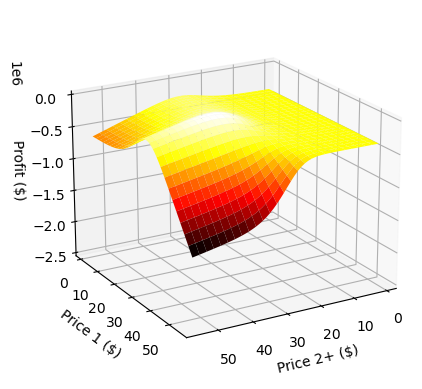

In [30]:
# view influence of constant pricing on 12 month profit
from matplotlib import cm
from matplotlib.ticker import LinearLocator
prices = np.linspace(1,55,55)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X, Y = np.meshgrid(prices, prices)
Z = -profit

surf = ax.plot_surface(X, Y, Z, cmap=cm.hot,
                       linewidth=0, antialiased=True)

ax.set_xlabel('Price 2+ ($)')
ax.set_ylabel('Price 1 ($)')
ax.set_zlabel('Profit ($)')
ax.set_zlim([-2500000, 0])
ax.zaxis.set_major_locator(LinearLocator(6))
#ax.zaxis.set_major_formatter('{x:.00f}')

ax.view_init(20, 60)
plt.show()

In [15]:
# naive strategy
price_schedule = [25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]
price_schedule_first_ride = [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
new_users_schedule = [500, 450, 400, 400, 400, 300, 300, 300, 200, 200, 200, 0]
schedule = price_schedule + price_schedule_first_ride + new_users_schedule # need to combine for optimization

In [31]:
# profit of naive strategy
naive_profit = pricing_strategy(schedule)
-naive_profit

-21849.231888774433

Our naive strategy is not profitable. Let's see if we can move towards a profitable one by framing our pricing strategy as an optimization problem.

As profit is higher at decreasing values (when negative), we want to minimize this.

We have value boundaries:
* monthly price must be >= 0
* monthly number of new users must be <= 1000

In [17]:
bounds = Bounds([0] * len(price_schedule) + [0] * len(price_schedule_first_ride) + [0] * len(new_users_schedule),
                [100] * len(price_schedule) + [100] * len(price_schedule_first_ride) + [1000] * len(new_users_schedule))

We also have an inequality constraint:
* sum of new users across 12 months must be <= 10000

In [18]:
def constraint(x):
    return 10000 - sum(x[24:])
con = {'type': 'ineq', 'fun': constraint}

With bounds and an inequality constraint, we can treat our problem as a trust-region constrained optimization.

Let's see how it performs after 100 iterations.

In [19]:
res1 = minimize (pricing_strategy,
                schedule,
                bounds = bounds,
                constraints = con,
                options = {'maxiter': 100,
                          'verbose': 3
                          },
                method = 'trust-constr',
                jac = '3-point',
                hess = SR1()
                )

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  73   |   0   | +2.1849e+04 | 1.00e+00 | 6.56e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  146  |   1   | +2.0562e+04 | 7.00e+00 | 6.65e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  219  |   2   | +6.0900e+03 | 4.90e+01 | 6.88e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|   4   |  365  |   3   | +6.0900e+03 | 2.45e+01 | 6.88e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|   5   |  438  |   7   | -1.9235e+04 | 1.33e+02 | 6.82e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   6   |  511  |  11   | -2.2027e+04 | 1.33e+02 | 2.19e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   7   |  584  |  14   | -2.2326e+04 | 1.33e+02 | 1.44e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   8   |  657  |  19   | -2.2801e+04 | 1.33e+02 | 1.19e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   9   |  730  |  23   | -2.2843e+04 | 1.33e+02 | 2.98e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|  10   |  803  |  30   | -2.2865e+04 | 1.33e+02 | 7.61e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|  11   |  876  |  35   | -2.2891e+04 | 1.33e+02 | 2.30e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|  12   |  949  |  45   | -2.2946e+04 | 1.33e+02 | 8.44e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  13   | 1095  |  46   | -2.2946e+04 | 6.66e+01 | 8.44e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  14   | 1241  |  55   | -2.2946e+04 | 6.66e+00 | 8.44e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|  15   | 1387  |  56   | -2.2946e+04 | 3.33e+00 | 8.44e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  16   | 1533  |  57   | -2.2946e+04 | 1.67e+00 | 8.44e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  17   | 1679  |  58   | -2.2946e+04 | 8.33e-01 | 8.44e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  18   | 1752  |  60   | -2.2988e+04 | 1.67e+00 | 4.32e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  19   | 1898  |  61   | -2.2988e+04 | 8.33e-01 | 4.32e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  20   | 1971  |  63   | -2.3017e+04 | 1.67e+00 | 2.42e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  21   | 2117  |  65   | -2.3017e+04 | 8.33e-01 | 2.42e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  22   | 2190  |  68   | -2.3032e+04 | 8.33e-01 | 4.94e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  23   | 2263  |  72   | -2.3060e+04 | 5.83e+00 | 2.47e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  24   | 2409  |  77   | -2.3060e+04 | 2.92e+00 | 2.47e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  25   | 2555  |  78   | -2.3060e+04 | 1.46e+00 | 2.47e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  26   | 2628  |  84   | -2.3088e+04 | 2.92e+00 | 4.54e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  27   | 2701  |  93   | -2.3120e+04 | 5.83e+00 | 7.98e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  28   | 2774  |  105  | -2.3260e+04 | 2.18e+01 | 4.56e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  29   | 2920  |  112  | -2.3260e+04 | 7.40e+00 | 4.56e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  30   | 3066  |  113  | -2.3260e+04 | 3.70e+00 | 4.56e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  31   | 3139  |  124  | -2.3351e+04 | 2.59e+01 | 7.85e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  32   | 3212  |  139  | -2.3801e+04 | 1.38e+02 | 9.17e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|  33   | 3358  |  148  | -2.3801e+04 | 1.57e+01 | 9.17e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  34   | 3504  |  149  | -2.3801e+04 | 7.84e+00 | 9.17e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  35   | 3577  |  158  | -2.4071e+04 | 5.48e+01 | 9.85e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  36   | 3650  |  167  | -2.5288e+04 | 3.84e+02 | 1.51e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  37   | 3796  |  171  | -2.5288e+04 | 3.84e+01 | 1.51e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  38   | 3942  |  172  | -2.5288e+04 | 1.92e+01 | 1.51e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  39   | 4088  |  173  | -2.5288e+04 | 9.60e+00 | 1.51e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  40   | 4234  |  174  | -2.5288e+04 | 3.52e+00 | 1.51e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  41   | 4307  |  176  | -2.5400e+04 | 3.52e+00 | 3.55e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  42   | 4380  |  181  | -2.5484e+04 | 3.52e+00 | 3.16e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  43   | 4453  |  188  | -2.5903e+04 | 7.04e+00 | 7.15e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  44   | 4526  |  195  | -2.6109e+04 | 4.93e+01 | 7.96e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  45   | 4599  |  203  | -2.6834e+04 | 9.85e+01 | 4.51e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  46   | 4672  |  214  | -2.8114e+04 | 1.33e+02 | 3.03e+02 | 9.13e-04 | 1.00e+00 |  1.00e-01   |   2   |
|  47   | 4745  |  227  | -3.1427e+04 | 9.33e+02 | 6.40e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  48   | 4818  |  231  | -3.1427e+04 | 9.33e+01 | 6.40e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  49   | 4964  |  244  | -3.1427e+04 | 1.55e+

C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  50   | 5110  |  245  | -3.1427e+04 | 7.74e+00 | 6.40e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  51   | 5256  |  247  | -3.1427e+04 | 3.87e+00 | 6.40e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  52   | 5329  |  248  | -3.2985e+04 | 7.74e+00 | 4.67e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  53   | 5475  |  252  | -3.2985e+04 | 2.94e+00 | 4.67e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  54   | 5548  |  258  | -3.3590e+04 | 5.87e+00 | 1.96e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  55   | 5694  |  262  | -3.3590e+04 | 1.86e+00 | 1.96e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  56   | 5767  |  268  | -3.3824e+04 | 1.30e+01 | 1.15e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  57   | 5913  |  271  | -3.3824e+04 | 3.53e+00 | 1.15e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  58   | 6059  |  272  | -3.3824e+04 | 1.77e+00 | 1.15e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  59   | 6132  |  278  | -3.3923e+04 | 1.24e+01 | 6.11e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  60   | 6278  |  286  | -3.3923e+04 | 2.93e+00 | 6.11e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  61   | 6351  |  295  | -3.3993e+04 | 5.85e+00 | 7.01e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  62   | 6497  |  303  | -3.3993e+04 | 1.38e+00 | 7.01e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  63   | 6570  |  307  | -3.4069e+04 | 9.68e+00 | 2.07e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  64   | 6643  |  312  | -3.4238e+04 | 1.94e+01 | 8.19e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  65   | 6716  |  320  | -3.4677e+04 | 1.36e+02 | 8.33e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  66   | 6862  |  321  | -3.4677e+04 | 6.78e+01 | 8.33e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  67   | 7008  |  322  | -3.4677e+04 | 3.39e+01 | 8.33e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  68   | 7154  |  323  | -3.4677e+04 | 1.69e+01 | 8.33e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  69   | 7300  |  324  | -3.4677e+04 | 8.47e+00 | 8.33e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  70   | 7446  |  326  | -3.4677e+04 | 4.24e+00 | 8.33e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  71   | 7592  |  327  | -3.4677e+04 | 2.12e+00 | 8.33e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  72   | 7665  |  329  | -3.4733e+04 | 2.12e+00 | 1.49e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  73   | 7811  |  334  | -3.4733e+04 | 1.06e+00 | 1.49e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  74   | 7884  |  335  | -3.4919e+04 | 1.06e+00 | 1.03e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  75   | 7957  |  341  | -3.4970e+04 | 7.41e+00 | 2.56e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  76   | 8030  |  350  | -3.5111e+04 | 5.19e+01 | 5.43e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  77   | 8176  |  356  | -3.5111e+04 | 5.19e+00 | 5.43e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  78   | 8322  |  382  | -3.5111e+04 | 2.59e+00 | 5.43e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  79   | 8468  |  383  | -3.5111e+04 | 1.30e+00 | 5.43e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  80   | 8614  |  384  | -3.5111e+04 | 6.49e-01 | 5.43e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  81   | 8687  |  385  | -3.5169e+04 | 4.54e+00 | 3.94e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  82   | 8833  |  389  | -3.5169e+04 | 2.23e+00 | 3.94e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  83   | 8906  |  400  | -3.5246e+04 | 1.56e+01 | 3.72e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  84   | 9052  |  406  | -3.5246e+04 | 3.61e+00 | 3.72e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  85   | 9198  |  407  | -3.5246e+04 | 1.80e+00 | 3.72e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  86   | 9344  |  408  | -3.5246e+04 | 9.02e-01 | 3.72e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  87   | 9490  |  409  | -3.5246e+04 | 4.51e-01 | 3.72e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  88   | 9563  |  414  | -3.5270e+04 | 3.16e+00 | 1.63e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  89   | 9636  |  422  | -3.5350e+04 | 2.21e+01 | 6.14e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  90   | 9782  |  425  | -3.5350e+04 | 9.82e+00 | 6.14e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  91   | 9928  |  426  | -3.5350e+04 | 4.91e+00 | 6.14e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  92   | 10074 |  427  | -3.5350e+04 | 2.45e+00 | 6.14e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  93   | 10220 |  435  | -3.5350e+04 | 1.23e+00 | 6.14e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  94   | 10293 |  441  | -3.5375e+04 | 2.45e+00 | 5.42e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  95   | 10366 |  453  | -3.5463e+04 | 1.72e+01 | 3.73e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  96   | 10512 |  465  | -3.5463e+04 | 2.93e+00 | 3.73e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  97   | 10658 |  466  | -3.5463e+04 | 1.47e+00 | 3.73e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |


C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|  98   | 10804 |  467  | -3.5463e+04 | 7.33e-01 | 3.73e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  99   | 10877 |  468  | -3.5465e+04 | 7.33e-01 | 1.12e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   3   |
|  100  | 10950 |  474  | -3.5483e+04 | 7.33e-01 | 6.20e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |

The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 10950, CG iterations: 474, optimality: 6.20e+01, constraint violation: 0.00e+00, execution time: 1.9e+05 s.


In [25]:
improved_schedule = res1.x.astype(int)

print(f'initial price strategy:\n {schedule}\n')
print(f'improved price strategy after 100 iterations: \n{improved_schedule}')
print(f'Profit: \n {pricing_strategy(improved_schedule)*-1}')

initial price strategy:
 [25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 500, 450, 400, 400, 400, 300, 300, 300, 200, 200, 200, 0]

improved price strategy after 100 iterations: 
[ 32  32  32  32  31  31  31  31  30  30  28  26  36  36  36  36  36  36
  36  36  35  35  33  31 729 642 575 545 518 356 326 296 140 228 160   0]
Profit: 
 34274.93999134563


Our optimizer did not converge after 100 iterations, but did go from a deficit at our naive guess to an improved price strategy schedule that produces a profit of $34,274.94.

Let's next examine how the pricing strategy changed.

In [21]:
def plot_schedules(schedule, improved_schedule):

    months = np.linspace(1,12,12)
    fig = plt.figure()

    plt.subplot(3,1,1)
    plt.plot(months, schedule[:12], c = 'b', label = 'Starting')
    plt.plot(months, improved_schedule[:12], c = 'r', label = 'Improved')
    plt.ylabel('Price 2+ ($)')
    plt.ylim([0,60])
    plt.legend(loc = 'upper right')


    plt.subplot(3,1,2)
    plt.plot(months, schedule[12:24], c = 'b', label = 'Starting')
    plt.plot(months, improved_schedule[12:24], c = 'r', label = 'Improved')
    plt.ylabel('Price 1 ($)')
    plt.ylim([0,60])
    plt.legend(loc = 'upper right')


    plt.subplot(3,1,3)
    plt.plot(months, schedule[24:], c = 'b', label = 'Starting')
    plt.plot(months, improved_schedule[24:], c = 'r', label = 'Improved')    
    plt.xlabel('Month')
    plt.ylabel('# new users')
    plt.legend(loc = 'upper right')

    fig.tight_layout()

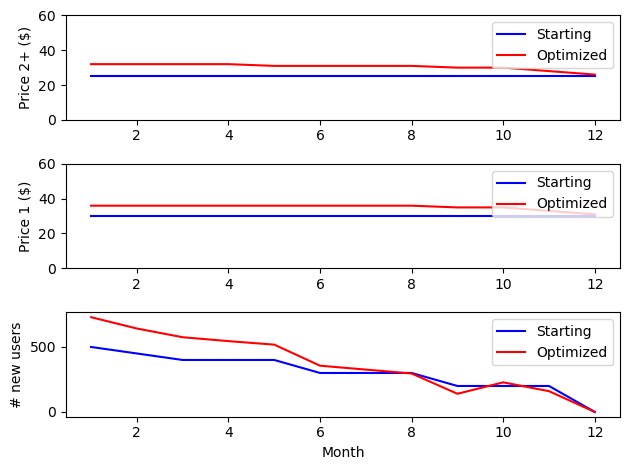

In [22]:
plot_schedules(schedule, optimized_schedule)

Our naive guess seems to have been on the right track! A few observations:

1. The pricing strategy is better when more new users are recruited early on and fewer new users are recruited at progressively later months. This highlights the importance of retaining existing users for the venture to be profitable.

2. The pricing strategy works better when drivers are paid slightly more than initially thought.

3. There is a very minimal difference between price paid to the driver for the first matched ride vs. the second or further matched rides.

Depending on rider and driver feedback, we can further tune to enhance profit in the following ways:

1. Increase revenues by charging riders more than $40.

2. Increase revenues by increasing the number of requests a rider makes in a given month (e.g. rider incentives like a discount after making 3+ requests).

3. Decrease expenses by lowering new rider acquisition cost below $30.

4. Decrease expenses by increasing probability of a driver accepting a ride at a given pay (e.g. driver incentives like a bonus after a certain number of accepted rides, overfilling a single ride request with multiple drivers to boost match rate).

## Appendices

Appendix A: Visualize Poisson distribution as lamda increases

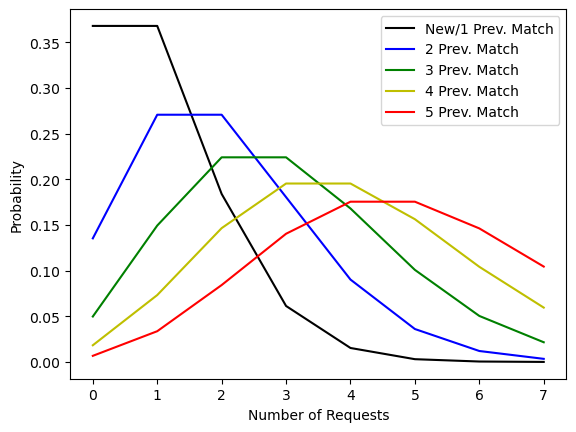

In [32]:
fig, ax = plt.subplots(1, 1)

x = np.linspace(0,7,8)
y1 = poisson.pmf(x,1)
y2 = poisson.pmf(x,2)
y3 = poisson.pmf(x,3)
y4 = poisson.pmf(x,4)
y5 = poisson.pmf(x,5)


ax.plot(x, y1, 'k', label = 'New/1 Prev. Match')
ax.plot(x, y2, 'b', label = '2 Prev. Match')
ax.plot(x, y3, 'g', label = '3 Prev. Match')
ax.plot(x, y4, 'y', label = '4 Prev. Match')
ax.plot(x, y5, 'r', label = '5 Prev. Match')
plt.ylabel('Probability')
plt.xlabel('Number of Requests')
plt.legend(loc = 'upper right')
